**Importing packages**

In [1]:
#Basic packages

import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Packages for modeling, selection and evaluation

from fastai.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

In [3]:
%matplotlib inline 

**Reading the data & analysing it**

The data is read from the file 'Tweets.csv' originally created by Crowdflower and available for download on Kaggle here: https://www.kaggle.com/crowdflower/twitter-airline-sentiment

The data is read from the CSV file into a Pandas DataFrame, allowing us to have a look at all the columns, analysing which ones we could use for the current task.

In [4]:
df = pd.read_csv('/content/Tweets.csv')
pd.set_option('display.max_colwidth', -1)
df = df.reindex(np.random.permutation(df.index)) # this will allow us to take a look at some random rows of the dataset, rather than the first five
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


tweet_id  ...               user_timezone
14585  569595595754639360  ...  NaN                       
10647  569015470025793536  ...  Eastern Time (US & Canada)
8686   568023553548922880  ...  Eastern Time (US & Canada)
6425   567866673325285376  ...  NaN                       
10127  569527721916796929  ...  Eastern Time (US & Canada)

[5 rows x 15 columns]

In [5]:
# (tweets, categories) or (rows without header, columns)

df.shape

(14640, 15)

In [6]:
# Counting the number of tweets each airline has received 

df.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America    504 
Name: airline, dtype: int64

Text(0, 0.5, 'Number of tweets')

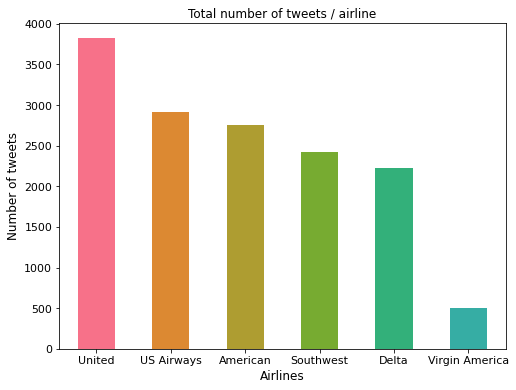

In [7]:
# Plotting the number of tweets each airline has received 

colors = sns.color_palette("husl", 10) 
pd.Series(df["airline"]).value_counts().plot(kind = "bar", color = colors, figsize = (8,6), fontsize = 11,rot = 0, title = "Total number of tweets / airline")
plt.xlabel('Airlines', fontsize = 12)
plt.ylabel('Number of tweets', fontsize = 12)

In [8]:
# Counting the number of tweets for each type of sentiment

df.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Text(0, 0.5, 'Number of tweets')

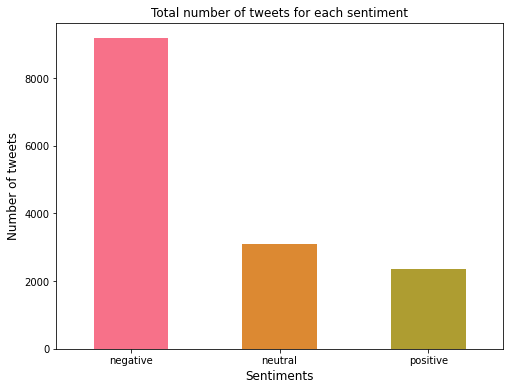

In [9]:
# Plotting the number of tweets for each type of sentiment

#bar_chart

colors = sns.color_palette("husl", 10)
pd.Series(df["airline_sentiment"]).value_counts().plot(kind = "bar", color = colors, figsize = (8,6), rot = 0, title = "Total number of tweets for each sentiment")
plt.xlabel('Sentiments', fontsize = 12)
plt.ylabel('Number of tweets', fontsize = 12)

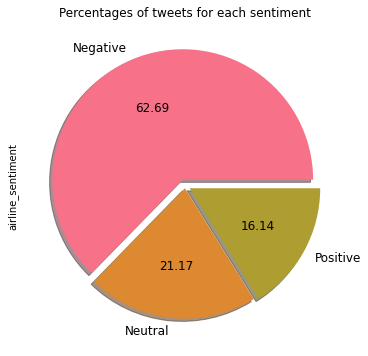

In [51]:
#pie_chart

colors = sns.color_palette("husl", 10)
pd.Series(df["airline_sentiment"]).value_counts().plot(kind = "pie",colors = colors, labels = ["Negative", "Neutral", "Positive"],explode = [0.05,0.02,0.04],
          shadow = True, autopct = '%.2f', fontsize = 12, figsize = (6, 6), title = "Percentages of tweets for each sentiment")

In [11]:
# Counting the number of tweets for each type of sentiment according to each airline

air_senti=pd.crosstab(df.airline, df.airline_sentiment)
air_senti

airline_sentiment  negative  neutral  positive
airline                                       
American           1960      463      336     
Delta              955       723      544     
Southwest          1186      664      570     
US Airways         2263      381      269     
United             2633      697      492     
Virgin America     181       171      152

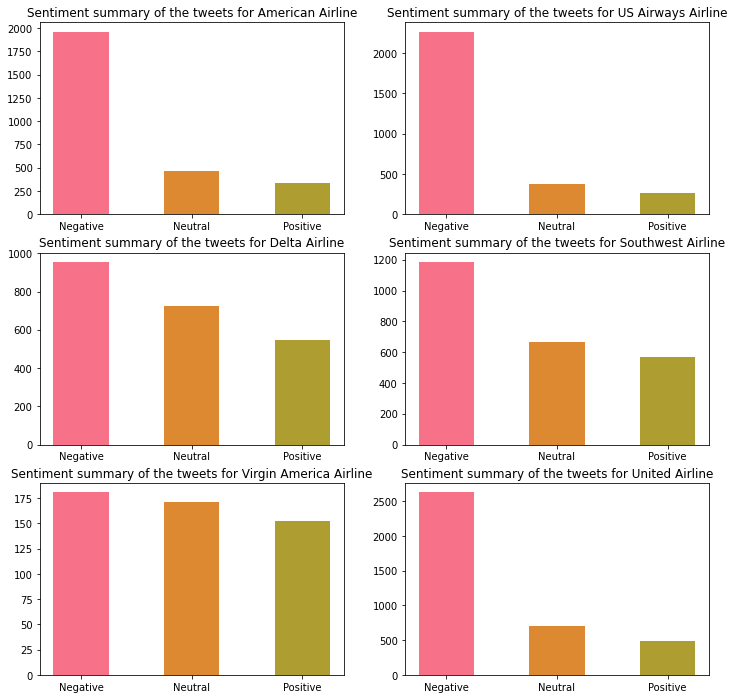

In [12]:
# Plotting the number of tweets for each type of sentiment according to each airline

def plot_sub_sentiment(Airline):
    pdf = df[df['airline']==Airline]
    count = pdf['airline_sentiment'].value_counts()
    Index = [1,2,3]
    color=sns.color_palette("husl", 10)
    plt.bar(Index, count, width = 0.5,color = color)
    plt.xticks(Index,['Negative','Neutral','Positive'])
    plt.title('Sentiment summary of the tweets for' + " " + Airline + " " + "Airline")

airline_name = df['airline'].unique()
plt.figure(1,figsize=(12,12))
for i in range(6):
    plt.subplot(3,2,i+1)
    plot_sub_sentiment(airline_name[i])

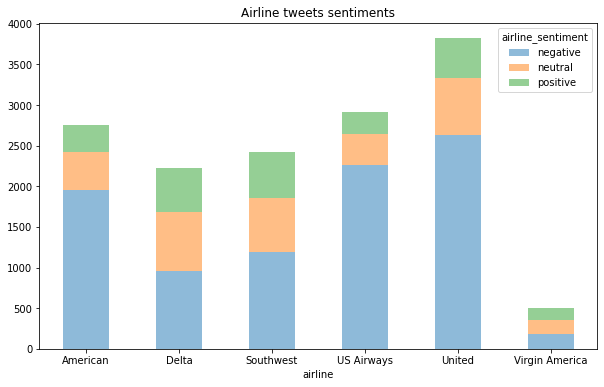

In [13]:
#2.0

pd.crosstab(index = df["airline"],columns = df["airline_sentiment"]).plot(kind='bar', figsize = (10, 6), alpha = 0.5, rot=0, stacked = True, title = "Airline tweets sentiments")

In [14]:
# Counting the percentages of tweets for each type of sentiment according to each airline

percent = air_senti.apply(lambda a: a / a.sum() * 100, axis = 1)
percent

airline_sentiment   negative    neutral   positive
airline                                           
American           71.040232  16.781443  12.178325
Delta              42.979298  32.538254  24.482448
Southwest          49.008264  27.438017  23.553719
US Airways         77.686234  13.079300  9.234466 
United             68.890633  18.236525  12.872841
Virgin America     35.912698  33.928571  30.158730

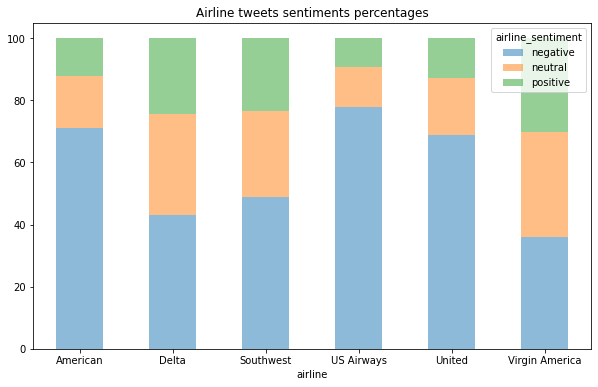

In [15]:
# Plotting the percentages of tweets for each type of sentiment according to each airline

percent.plot(kind = 'bar', figsize = (10, 6), alpha = 0.5, rot = 0,stacked = True, title = "Airline tweets sentiments percentages")

In [16]:
# Counting the total number of negative reasons

df.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight               847 
Lost Luggage                   724 
Bad Flight                     580 
Flight Booking Problems        529 
Flight Attendant Complaints    481 
longlines                      178 
Damaged Luggage                74  
Name: negativereason, dtype: int64

Text(0, 0.5, 'Number of tweets')

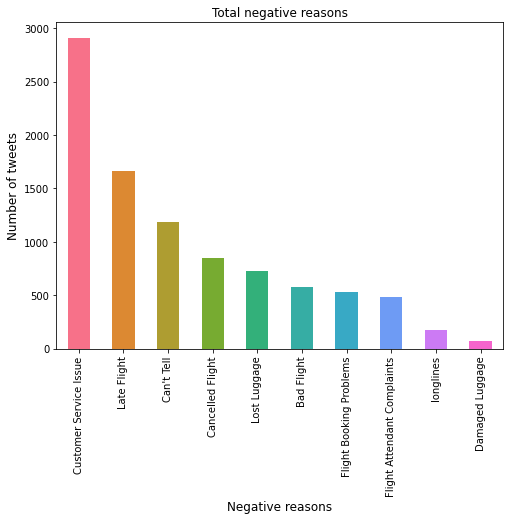

In [17]:
# Plotting all the negative reasons 

color = sns.color_palette("husl", 10)
pd.Series(df["negativereason"]).value_counts().plot(kind = "bar", color = color,figsize = (8,6),title = "Total negative reasons")
plt.xlabel('Negative reasons', fontsize = 12)
plt.ylabel('Number of tweets', fontsize = 12)

**Wordclouds for tweets featuring negative, neutral and positive sentiments**

The larger the words appear in the wordcloud image, the more frequent the words are in the given dataset.

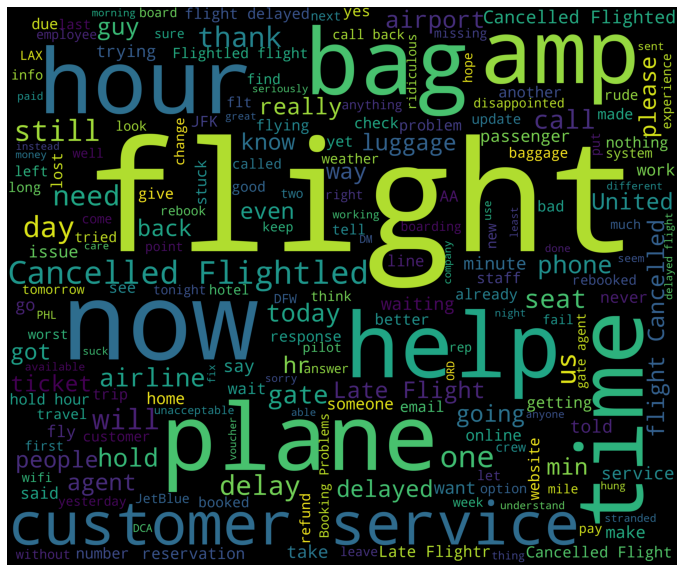

In [18]:
# Wordcloud for negative tweets

new_df = df[df['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', width = 3000, height = 2500).generate(cleaned_word)
plt.figure(1, figsize = (12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

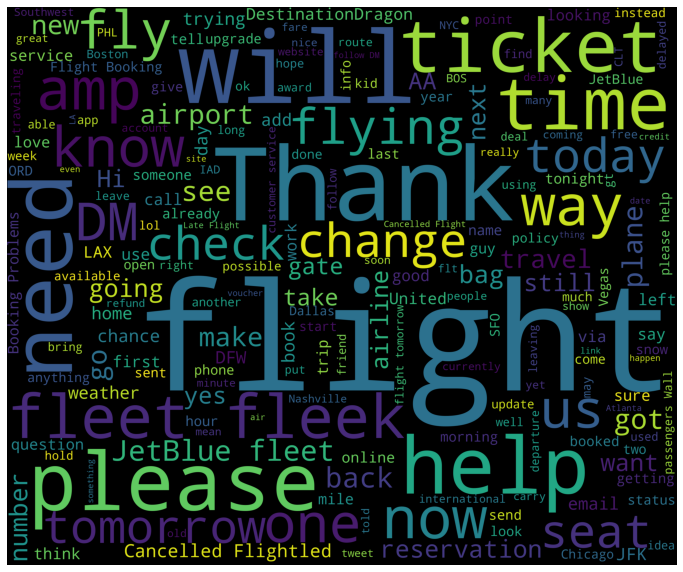

In [19]:
# Wordcloud for neutral tweets

new_df = df[df['airline_sentiment']=='neutral']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', width = 3000, height = 2500).generate(cleaned_word)
plt.figure(1, figsize = (12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

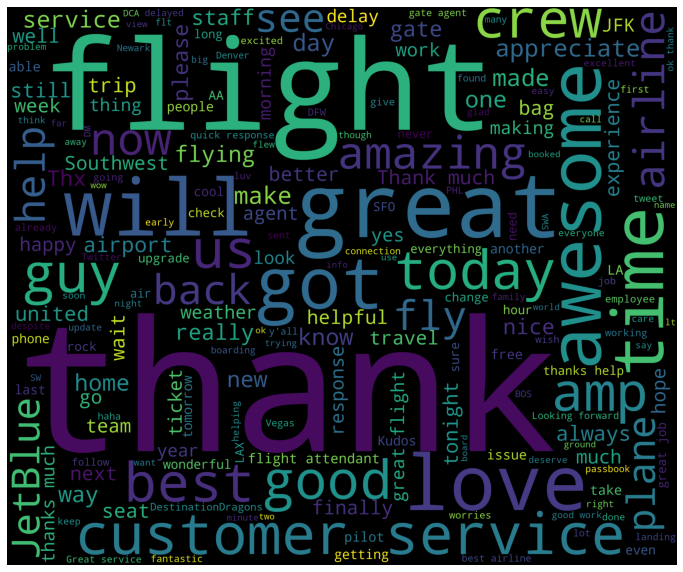

In [20]:
# Wordcloud for positive tweets

new_df = df[df['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', width = 3000, height = 2500).generate(cleaned_word)
plt.figure(1, figsize = (12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

No correlation between the number of positive / neutral tweets and the tweet length can be observed, but for negative tweets the distribution is heavily skewed towards longer tweets. This might happen due to the fact that the angrier the tweeters, the more they have to say / complain about. 

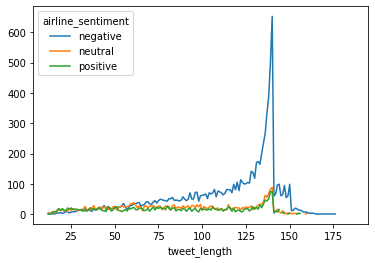

In [21]:
# Plotting the connection between the length of the tweets and the sentiments they are featuring

df['tweet_length'] = df['text'].apply(len)
df.groupby(['tweet_length', 'airline_sentiment']).size().unstack().plot(kind = 'line', stacked = False)

Taking into consideration the average and median sentiment confidence, it can be observed again that there is no visible relationship between the confidence and the length of the tweets.

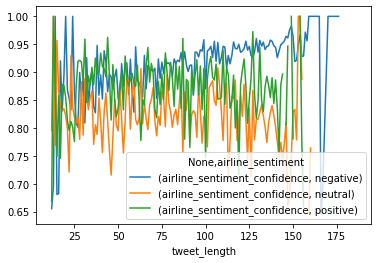

In [22]:
#average_sentiment_confidence

df[['tweet_length', 'airline_sentiment', 'airline_sentiment_confidence']].groupby(['tweet_length', 'airline_sentiment']).mean().unstack().plot(kind = 'line', stacked = False)

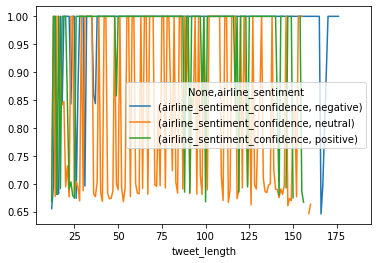

In [23]:
#median_sentiment_confidence

df[['tweet_length', 'airline_sentiment', 'airline_sentiment_confidence']].groupby(['tweet_length', 'airline_sentiment']).median().unstack().plot(kind = 'line', stacked = False)

Randomizing & splitting the data, then writing to CSVs

In [24]:
test_percentage = 0.1
df.sort_index(inplace = True)
cutoff = int(test_percentage * df.shape[0])
df[['airline_sentiment', 'text']][:cutoff].to_csv('/content/Tweets_filtered_test.csv', index = False, encoding = 'utf-8')
df[['airline_sentiment', 'text']][cutoff:].to_csv('/content/Tweets_filtered_train.csv', index = False, encoding = 'utf-8')
df[['text']][cutoff:].to_csv('/content/Tweets_text_only_train.csv', index = False, encoding = 'utf-8')

**Tokenization**

The data is read and new words are added to our dictionary. In addition, a numerical represantation of words will be created.


In [25]:
data = TextClasDataBunch.from_csv('.', '/content/Tweets_filtered_train.csv')
data.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


There are some changes that have been made to the text available in the dataset for an easier modeling:


*   splits on the symbols representing space and punctuation
*   the 's' are grouped together a single token
*   the contractions are separated ("did", "n't")
*   there are several special tokens starting with 'xx', each of them with a different meaning - they represent the aspects of language in a way that the computer can understand

In [26]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

The special FastAI tokens have the following meanings:


*   **xxunk:** *token used instead of unknown words (words not found in the vocabulary)*
*   **xxpad:** *token used as padding (so every text has the same length)*
*   **xxbos:** *indicates the beginning of a text*
*   **xxeos:** *indicates the end of a text*
*   **xxfld:** *represents separate parts of your document (several columns in a dataframe) like headline, body, summary, etc.*
*   **xxmaj:** *indicates that the next word starts with a capital*
*   **xxup:** *indicates that next word is written in all caps*
*   **xxrep:** *indicates that a character is repeated n times*
*   **xxwrep:** *indicates that a word is repeated n times*









Both the text and numerical formats of the dataset can be seen after the processing.

In [27]:
print(data.train_ds[0][0])
print(data.train_ds[1][0])
print(data.train_ds[2][0])

xxbos @usairways xxmaj gave up after more than 2 hours on hold . xxmaj still need that receipt ; last time it was promised , it never arrived . xxmaj help ? !
xxbos @jetblue ask @j_beatz247 but i teach marketing at a university and will gladly xxunk on customer service and how xxup not to treat passengers .
xxbos @americanair . xxmaj all i get is an automated system that hangs up on me . i finally get a message that some will call me back in 2 hours .


In [28]:
print(data.train_ds[0][0].data[:10])
print(data.train_ds[1][0].data[:10])
print(data.train_ds[2][0].data[:10])

[  2  24   5 477  78 114 124 192  69  77]
[   2   31  651 3865   52   11 2077 2078   43   15]
[  2  26   9   5  79  11  48  28  63 666]


**Language Model**

A language model will be created using the pre-trained **AWD_LSTM** model. The already existing weights resulted from the model being trained on the *WikiText-103* language modeling dataset will be applied. This will provide a word embedding scheme that aligns with the corpus of airlines tweets and will hopefully capture enough "meaning" in each word. Due to the fact that tweets sometimes do not obey conventional spelling and grammar rules (especially hastags), the language model presented here won't be optimal.

In [29]:
bs = 24
seed = 333

In [30]:
# Ingesting the data again, but with a 10% holdout that will be used to calibrate the language model

data_lm = (TextList.from_csv('.', '/content/Tweets_text_only_train.csv')
            .random_split_by_pct(0.1, seed = seed)
           # split randomly and keep 10% for validation
            .label_for_lm()           
           # labeling accordingly in order to create a language model
            .databunch(bs = bs))
data_lm.save('/content/data_lm.pkl')

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [31]:
# data_lm = load_data(path, 'data_lm.pkl', bs=bs)
data_lm.show_batch()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 5.25E-02


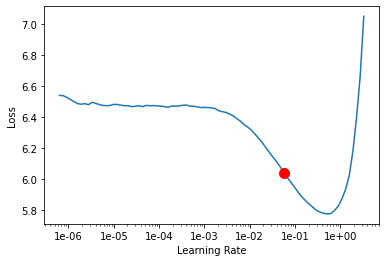

In [32]:
#Creating the language model

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult = 0.3)
learn.lr_find()   # find the learning rate by running a few epochs on the model to plot loss, and then calculate the minimum gradient
learn.recorder.plot(suggestion = True)    # plot the learning rate graph
min_grad_lr = learn.recorder.min_grad_lr

In [33]:
learn.fit_one_cycle(2, min_grad_lr)   # uses large, cyclical learning rates to train models significantly quicker and with higher accuracy

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 7.59E-06


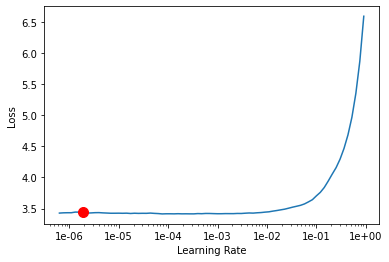

In [34]:
learn.save('fit_head')
#learn.load('fit_head')
learn.unfreeze()    # unfreezing weights 
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [35]:
learn.fit_one_cycle(10, 1e-3)   # training the rest of the NN

Save the encoder in order to use it for the classification model.

In [36]:
learn.save('fine_tuned')
learn.save_encoder('fine_tuned_enc')

Making some predictions (they won't be too meaningful tho):

In [37]:
TEXT = "I liked "
N_WORDS = 40
N_SENTENCES = 3
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked  you guys ! xxbos @southwestair absolutely disgusting the way i was treated . i was on the floor and my flight got Cancelled Flightled . i have n't been done to this airline . xxbos @jetblue Yes
I liked  @usairways Do n't worry you wo n't steal anymore , you make it impossible to book with you . xxbos @americanair i do n't want to wait on hold for an hour before my flight tomorrow . Can
I liked  u @americanair DM me and i 'll do it xxbos @jetblue Really ! ! Did n't see that i had a private jet to make a car seat ! It 's not about weather ! xxbos


**Classification Model**

Next, we'll load the previously saved language model encoder into the classifier, which has a similar LSTM architecture but will predict the sentiment of the tweet instead of the next word in a tweet. 

In [38]:
data_clas = (TextList.from_csv('.', '/content/Tweets_filtered_train.csv', cols = 'text')               
             .random_split_by_pct(0.1, seed = seed)
             .label_from_df(cols = 0)
             .databunch(bs = bs))
data_clas.save('/content/data_clas.pkl')
data_clas.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [39]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11859 items)
x: TextList
xxbos @united the delay is due to customer service for 20 people ? xxmaj what about the xxup xxunk - xxup service you provided for 100 + ? # xxunk # xxunk,xxbos @united he is so excellent and so reliable :) # happycustomer,xxbos @united but again xxup united xxup xxunk xxup give 2 xxup xxunk xxup about xxup their xxup customers,xxbos @united xxmaj she is travelling from xxmaj xxunk ( xxmaj australia ) to xxmaj bogota ( xxmaj xxunk ) tomorrow,xxbos @united xxmaj hi . xxmaj my relative 's xxmaj flight xxmaj booking xxmaj problems number is xxup xxunk . xxmaj her name is xxmaj xxunk xxmaj xxunk xxmaj xxunk . xxmaj thank you
y: CategoryList
negative,positive,negative,neutral,neutral
Path: .;

Valid: LabelList (1317 items)
x: TextList
xxbos @usairways stuck on xxmaj tarmac for 30 mins at xxup phl waiting for someone to load baggage , ridiculous http : / / t.co / xxunk,xxbos @southwestair i consider myself a loyal

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-01
Min loss divided by 10: 1.74E-02


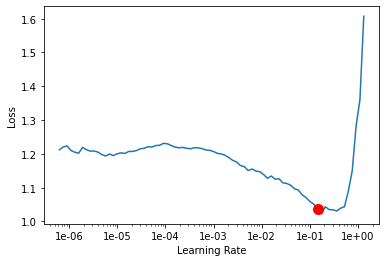

In [40]:
# find and plot the learning rate

learn.lr_find()
learn.recorder.plot(suggestion = True)
min_grad_lr = learn.recorder.min_grad_lr

In order to train the classifier, we will use a technique called **gradual unfreezing**. We can start by training the last few layers, then go backwards and unfreeze and train layers before. We can also track our loss function over the epochs.

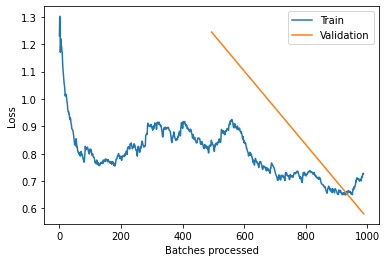

In [41]:
learn.fit_one_cycle(2, min_grad_lr)
learn.recorder.plot_losses()

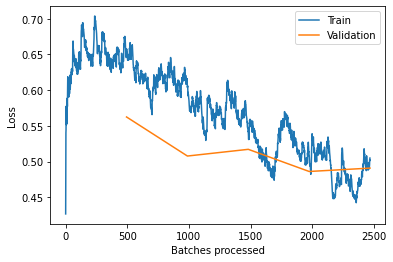

In [42]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(5e-3, 2e-3), moms=(0.8,0.7))
learn.recorder.plot_losses()

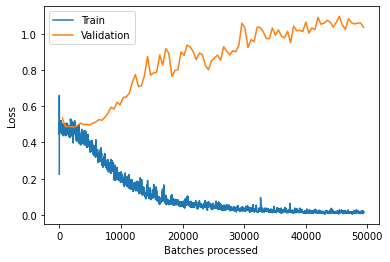

In [43]:
learn.unfreeze()
learn.fit_one_cycle(100, slice(2e-3/100, 2e-3), moms=(0.8,0.7))
learn.recorder.plot_losses()

In [52]:
learn.predict("I enjoyed the flight, thank you")

(Category tensor(2), tensor(2), tensor([2.6778e-04, 1.4798e-03, 9.9825e-01]))

In [53]:
learn.predict("Service was terrible, not flying again with you!!")

(Category tensor(0), tensor(0), tensor([1.0000e+00, 3.2416e-11, 6.4484e-14]))

**Performance evaluation**

Text(0, 0.5, 'Number of tweets')

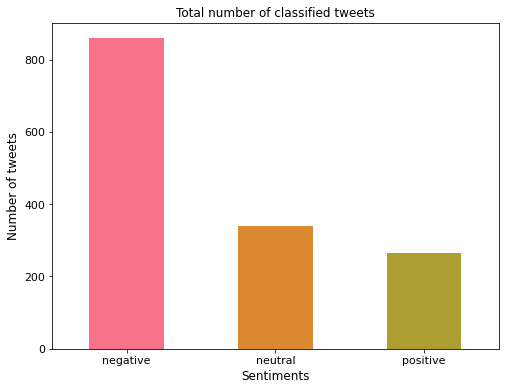

In [45]:
test_df = pd.read_csv("/content/Tweets_filtered_test.csv", encoding = "utf-8")
colors = sns.color_palette("husl", 10) 
pd.Series(test_df["airline_sentiment"]).value_counts().plot(kind = "bar", color = colors, figsize = (8,6), fontsize = 11,rot = 0, title = "Total number of classified tweets")
plt.xlabel('Sentiments', fontsize = 12)
plt.ylabel('Number of tweets', fontsize = 12)

In [46]:
test_df['pred_sentiment'] = test_df['text'].apply(lambda row: str(learn.predict(row)[0]))
print("Test Accuracy: ", accuracy_score(test_df['airline_sentiment'], test_df['pred_sentiment']))

Test Accuracy:  0.7937158469945356


In [47]:
test_df[:20]

airline_sentiment  ... pred_sentiment
0   neutral           ...  neutral      
1   positive          ...  negative     
2   neutral           ...  negative     
3   negative          ...  negative     
4   negative          ...  negative     
5   negative          ...  negative     
6   positive          ...  negative     
7   neutral           ...  negative     
8   positive          ...  positive     
9   positive          ...  positive     
10  neutral           ...  neutral      
11  positive          ...  positive     
12  positive          ...  positive     
13  positive          ...  positive     
14  positive          ...  positive     
15  negative          ...  neutral      
16  positive          ...  positive     
17  negative          ...  negative     
18  positive          ...  positive     
19  positive          ...  positive     

[20 rows x 3 columns]

**Confusion matrix**

It shows the predicted sentiments and the actual sentiments of the tweets(negative, neutral and positive).The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

In [48]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize = False,
                          title = None,
                          cmap = plt.cm.PuBu):
   
    # Normalization can be applied by setting 'normalize=True'
  
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation = 'nearest', cmap = cmap)
    ax.figure.colorbar(im, ax = ax)
    # We want to show all the ticks...
    ax.set(xticks = np.arange(cm.shape[1]),
           yticks = np.arange(cm.shape[0]),
           # [...] and label them with the respective list entries
           xticklabels = classes, yticklabels = classes,
           title = title,
           ylabel = 'True label',
           xlabel = 'Predicted label')

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
             rotation_mode = "anchor")

    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha = "center", va = "center",
                    color = "white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

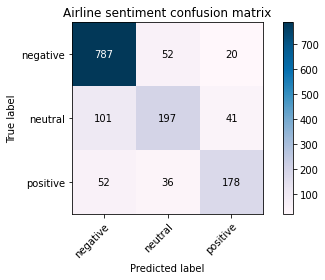

In [49]:
plot_confusion_matrix(test_df['airline_sentiment'], test_df['pred_sentiment'], classes=['negative', 'neutral', 'positive'], title='Airline sentiment confusion matrix')
plt.show()

As it can be observed in the above confusion matrix, the prediction accuracy is pretty high among the negative tweets. Regarding the neutral tweets, the model often misclassifies them as negative. As for the positive tweets, the overall accuracy of the model is decent, but there are still some tweets that get classified as negative. This may be due to the hashtags, informal style of the tweets, grammatical & spelling errors. 

In [50]:
test_df.loc[(test_df['airline_sentiment'] == 'positive') & (test_df['pred_sentiment'] == 'negative')]

airline_sentiment  ... pred_sentiment
1     positive          ...  negative     
6     positive          ...  negative     
47    positive          ...  negative     
114   positive          ...  negative     
118   positive          ...  negative     
136   positive          ...  negative     
264   positive          ...  negative     
273   positive          ...  negative     
303   positive          ...  negative     
323   positive          ...  negative     
342   positive          ...  negative     
358   positive          ...  negative     
362   positive          ...  negative     
369   positive          ...  negative     
392   positive          ...  negative     
421   positive          ...  negative     
427   positive          ...  negative     
453   positive          ...  negative     
454   positive          ...  negative     
459   positive          ...  negative     
463   positive          ...  negative     
477   positive          ...  negative     
480   positive          ...  negative     
488   positive          ...  negative     
521   positive          ...  negative     
552   positive          ...  negative     
589   positive          ...  negative     
607   positive          ...  negative     
611   positive          ...  negative     
663   positive          ...  negative     
690   positive          ...  negative     
699   positive          ...  negative     
721   positive          ...  negative     
722   positive          ...  negative     
723   positive          ...  negative     
758   positive          ...  negative     
773   positive          ...  negative     
806   positive          ...  negative     
834   positive          ...  negative     
886   positive          ...  negative     
941   positive          ...  negative     
998   positive          ...  negative     
1036  positive          ...  negative     
1037  positive          ...  negative     
1051  positive          ...  negative     
1093  positive          ...  negative     
1177  positive          ...  negative     
1181  positive          ...  negative     
1315  positive          ...  negative     
1352  positive          ...  negative     
1382  positive          ...  negative     
1415  positive          ...  negative     

[52 rows x 3 columns]